In [59]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

In [60]:
# 모델 불러오기
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

if not os.path.exists(model_file):
    model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'
    urllib.request.urlretrieve(model_url, model_file)

In [61]:
# 모델 로드
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

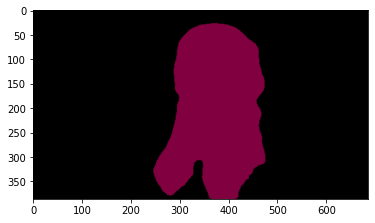

In [62]:
# semantic_segmentation 적용
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cute_dog.jpg' 
segvalues, output = model.segmentAsPascalvoc(img_path)
plt.imshow(output)
plt.show()

In [63]:
# 적용된 라벨 출력
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
dog


In [64]:
# 생성한 20개의 컬러맵 출력
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [65]:
# 강아지 색상 출력
colormap[12]

array([ 64,   0, 128])

(386, 686)


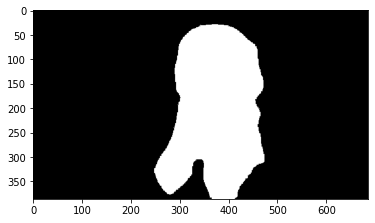

In [66]:
# 강아지 색상에 해당하는 것만 적용해서 출력
seg_color = (128 ,0 ,64)
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

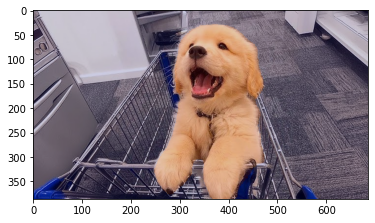

In [67]:
# 강아지에 seg map 적용 및 합성
img_orig = cv2.imread(img_path)
img_show = img_orig.copy()
img_mask = seg_map.astype(np.uint8) * 255
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.8, color_mask, 0.2, 0.0)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

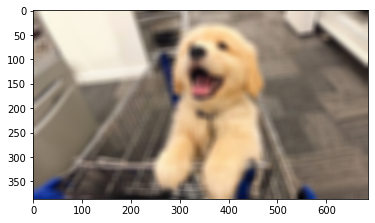

In [68]:
# 강아지에 blur 적용
img_orig_blur = cv2.blur(img_orig, (15,15))
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

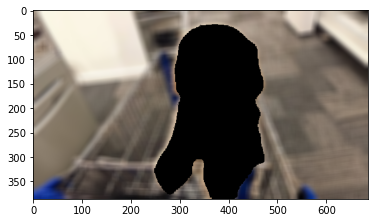

In [69]:
# 강아지에 mask 적용
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

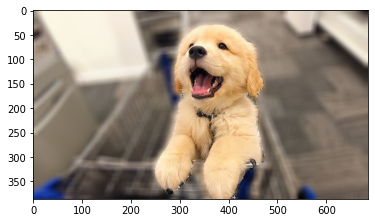

In [70]:
# 강아지 인물 사진 모드 완성
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

In [82]:
## 사람 배경 합성
# 사람 이미지 처리. 
human_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/wooill.jpg'
segvalues, output = model.segmentAsPascalvoc(human_path)
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

background
person


In [83]:
# 사람에 해당하는 color map 출력
colormap[15]

array([192, 128, 128])

(562, 1000)


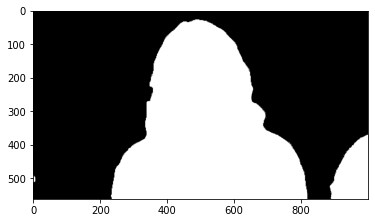

In [84]:
# segmentation_map 제작
seg_color = (128 ,128 ,192)
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

In [87]:
# 마스크 제작
h_orig = cv2.imread(human_path)
h_show = h_orig.copy()
h_orig_blur = cv2.blur(h_show, (13,13))
h_mask = seg_map.astype(np.uint8) * 255
h_mask_color = cv2.cvtColor(h_mask, cv2.COLOR_GRAY2BGR)
h_bg_mask = cv2.bitwise_not(h_mask_color)
h_bg_blur = cv2.bitwise_and(h_orig_blur, h_bg_mask)

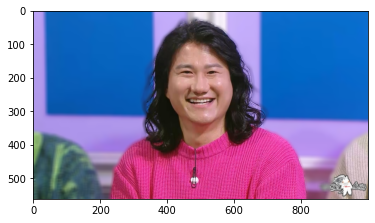

In [88]:
# 합성
img_concat_2 = np.where(h_mask_color==255, h_orig, h_bg_blur)
plt.imshow(cv2.cvtColor(img_concat_2, cv2.COLOR_BGR2RGB))
plt.show()

In [109]:
## 크로마키 합성
# background 불러오기
foreground = cv2.imread(human_path)
background_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/grass.jpg'
background = cv2.imread(background_path)
background = cv2.resize(background, (foreground.shape[1], foreground.shape[0]))

In [110]:
# 마스크 제작
# 인물 사진 모드 재활용
orig = cv2.imread(human_path)
show = orig.copy()
mask = seg_map.astype(np.uint8) * 255
mask_color = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

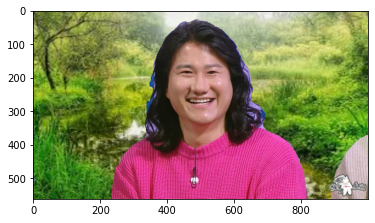

In [111]:
# 합성
img_concat_3 = np.where(mask_color==255, orig, background)
plt.imshow(cv2.cvtColor(img_concat_3, cv2.COLOR_BGR2RGB))
plt.show()

In [106]:
dog = cv2.imread(img_path)
human = cv2.imread(human_path)
dog = cv2.cvtColor(dog, cv2.COLOR_BGR2RGB)
human = cv2.cvtColor(human, cv2.COLOR_BGR2RGB)

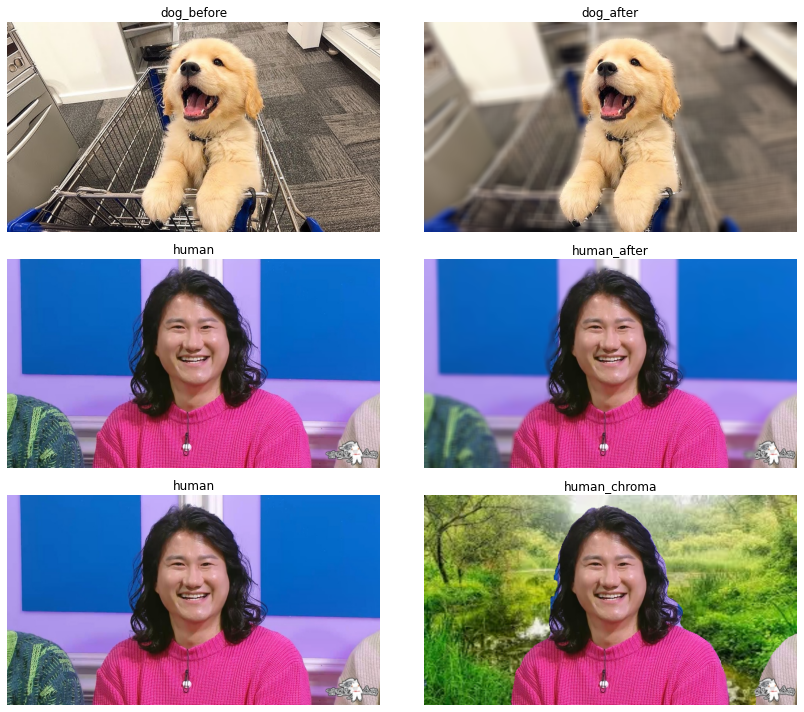

In [107]:
# 결과 분석
img_concat = cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB)
img_concat_2 = cv2.cvtColor(img_concat_2, cv2.COLOR_BGR2RGB)
img_concat_3 = cv2.cvtColor(img_concat_3, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 10))
plt.subplot(3, 2, 1)
plt.imshow(dog)
plt.title('dog_before')
plt.axis('off')

plt.subplot(3, 2, 2)
plt.imshow(img_concat)
plt.title('dog_after')
plt.axis('off')

plt.subplot(3, 2, 3)
plt.imshow(human)
plt.title('human')
plt.axis('off')

plt.subplot(3, 2, 4)
plt.imshow(img_concat_2)
plt.title('human_after')
plt.axis('off')

plt.subplot(3, 2, 5)
plt.imshow(human)
plt.title('human')
plt.axis('off')

plt.subplot(3, 2, 6)
plt.imshow(img_concat_3)
plt.title('human_chroma')
plt.axis('off')

plt.tight_layout()
plt.show()

In [108]:
## 문제점 분석
# 강아지 그림의 경우, 윤곽선이 조금 잘려 나가 있다. 다리 부위가 잘려 나가 있다.
# 사람 인물 모드는 자연스럽게 되었다.
# 사람 크로마키의 경우, 배경제거가 깔끔하게 되지 않아서 파란 빛이 퍼져 있다.(Halo현상). 옆에 사람 어깨가 포함됨.

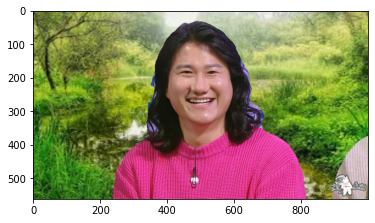

In [113]:
# 파란색 색상을 제거(완전히 제거 되지는 않음)
mask_color = cv2.GaussianBlur(mask_color, (5, 5), 0)
result = np.where(mask_color==255, orig, background)
result[np.where((result[:, :, 1] > 130) & (result[:, :, 0] < 100) & (result[:, :, 2] < 100))] = background[np.where((result[:, :, 1] > 130) & (result[:, :, 0] < 100) & (result[:, :, 2] < 100))]
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.show()